## Introduction
* use mean imputer
* use ECG data (all scaled ECG)
* concat training

## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q transformers
!pip install -q catboost

In [3]:
!unzip -qq /content/drive/MyDrive/'Colab Notebooks'/projects/etc/MAIC/'심전도 데이터를 활용한 나이 예측'/dataset/MAIC_data/kaggle_additional_data.zip

replace __results___files/__results___8_1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
GLOBAL_SEED = 42

import os
os.environ['PYTHONHASHSEED'] = str(GLOBAL_SEED)

import numpy as np # linear algebra
from numpy import random as np_rnd
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import random as rnd
import pickle
import gc
import time
from itertools import product

from torch.utils.data import TensorDataset, Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from transformers import get_polynomial_decay_schedule_with_warmup
from scipy.signal import spectrogram

from sklearn import metrics as skl_metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold
import catboost as cat

import warnings
warnings.filterwarnings(action='ignore')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    # python random
    rnd.seed(seed)
    # numpy random
    np_rnd.seed(seed)
    # RAPIDS random
    try:
        cupy.random.seed(seed)
    except:
        pass
    # tf random
    try:
        tf_rnd.set_seed(seed)
    except:
        pass
    # pytorch random
    try:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    except:
        pass

def pickleIO(obj, src, op="r"):
    if op=="w":
        with open(src, op + "b") as f:
            pickle.dump(obj, f)
    elif op=="r":
        with open(src, op + "b") as f:
            tmp = pickle.load(f)
        return tmp
    else:
        print("unknown operation")
        return obj

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error: Creating directory. ' + directory)

def findIdx(data_x, col_names):
    return [int(i) for i, j in enumerate(data_x) if j in col_names]

def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]

In [6]:
class CFG:
    debug = False
    dataset_root_path = r"/content/drive/MyDrive/Colab Notebooks/projects/etc/MAIC/심전도 데이터를 활용한 나이 예측/dataset/MAIC_data/"
    dataset_version = "v5"
    n_comp = 64
    TF = False
    TF_type = "indiv"
    use_ecg_stats = True
    use_ecg_seq = True
    pca_seq = True
    n_folds = 1 if debug else 5
    lead_names = ["std1", "std2", "std3", "v1", "v2", "v3", "v4", "v5", "v6", "augvr", "augvl", "augvf"]
    ecg_hz = 500

    epochs = 2 if debug else 30
    early_stopping_rounds = 10
    batch_size = 32
    eta = 5e-4
    weight_decay = 1e-4

In [7]:
prep_root_path = r"/content/drive/MyDrive/Colab Notebooks/projects/etc/MAIC/심전도 데이터를 활용한 나이 예측/dataset/prep_data/" + CFG.dataset_version + "/"

## Loading data

In [8]:
df_full = pickleIO(None, prep_root_path + "df_full.pkl", "r")
full_ecg_meta_feature = pickleIO(None, prep_root_path + "df_full_meta.pkl", "r").astype("float32")
full_ecg_seq_feature = np.load(r"/content/drive/MyDrive/Colab Notebooks/projects/etc/MAIC/심전도 데이터를 활용한 나이 예측/dataset/prep_data/" + "v1" + "/" + "full_ecg.npz")["ecg"].astype("float32")
fold_split = np.load(prep_root_path + "fold_split.npz")

In [9]:
full_ecg_meta_feature.shape

(43688, 444)

In [10]:
full_ecg_seq_feature.shape

(43688, 12, 500)

In [11]:
df_full.loc[df_full["age_type"] == "child", "age"].max(), df_full.loc[df_full["age_type"] == "adult", "age"].min()

(8.083333333, 19.0)

### Loading kaggle data


In [12]:
df_kaggle = {"age": [], "gender": [], "ecg": []}

for chunk in range(20):
    tmp = np.load(f"chunk{chunk}.npz")
    for k in df_kaggle.keys():
        df_kaggle[k].append(tmp[k])

del tmp; gc.collect()

639

In [13]:
kaggle_ecg = F.avg_pool1d(torch.from_numpy(np.concatenate(df_kaggle["ecg"]).astype("float32")), 10, 10).detach().cpu().numpy()
df_kaggle = pd.DataFrame({"age": np.concatenate(df_kaggle["age"]), "gender": np.concatenate(df_kaggle["gender"])})
df_kaggle["age_type"] = df_kaggle["age"].apply(lambda x: 1 if x >= 19 else 0)

In [14]:
kaggle_ecg.shape

(80876, 12, 500)

In [15]:
df_kaggle.shape

(80876, 3)

### Preprocessing

In [16]:
df_full["gender"] = df_full["gender"].apply(lambda x: 1 if x == "MALE" else 0).astype("int32")
df_full["age_type"] = df_full["age_type"].apply(lambda x: 1 if x == "adult" else 0).astype("int32")
df_full = df_full.drop("filename", axis=1)

In [17]:
df_full["fold"] = fold_split["fold_split"].astype("float32")
df_full["fold_adult"] = -1; df_full["fold_child"] = -1
df_full.loc[df_full["age_type"] == 1, "fold_adult"] = fold_split["adult"].astype("float32")
df_full.loc[df_full["age_type"] == 0, "fold_child"] = fold_split["child"].astype("float32")

In [18]:
df_full.shape

(43688, 6)

In [19]:
df_full

,gender,age,age_type,fold,fold_adult,fold_child
0,1,53.000000,1,0.0,2,-1
1,1,68.000000,1,1.0,0,-1
2,1,68.000000,1,0.0,0,-1
3,1,89.000000,1,1.0,0,-1
4,1,79.000000,1,1.0,2,-1
...,...,...,...,...,...,...
43683,1,0.666667,0,2.0,-1,0
43684,1,0.083333,0,4.0,-1,3
43685,0,5.833333,0,0.0,-1,1
43686,0,2.250000,0,2.0,-1,4


### Merging with kaggle data

In [20]:
df_full = pd.concat([df_full, df_kaggle], axis=0)
full_ecg_seq_feature = np.concatenate([full_ecg_seq_feature, kaggle_ecg])
del df_kaggle, kaggle_ecg; gc.collect()

0

In [21]:
df_full[["age", "fold_adult", "fold_child"]] = df_full[["age", "fold_adult", "fold_child"]].astype("float32")
df_full["age_type"] = df_full["age_type"].astype("int32")

In [22]:
full_ecg_seq_feature = full_ecg_seq_feature[df_full["age"] > 0]
df_full = df_full[df_full["age"] > 0].reset_index(drop=True)

In [23]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124316 entries, 0 to 124315
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   gender      124316 non-null  int32  
 1   age         124316 non-null  float32
 2   age_type    124316 non-null  int32  
 3   fold        43688 non-null   float32
 4   fold_adult  43688 non-null   float32
 5   fold_child  43688 non-null   float32
dtypes: float32(4), int32(2)
memory usage: 2.8 MB


In [24]:
df_full.shape

(124316, 6)

In [25]:
full_ecg_seq_feature.shape

(124316, 12, 500)

In [26]:
scaler_seq = {}
for target in df_full["age_type"].unique():
    scaler_seq[target] = {}
    tmp = full_ecg_seq_feature[df_full["age_type"] == target]
    for i in range(len(CFG.lead_names)):
        scaler_seq[target][i] = {"min": 0.0, "max": 0.0}
        scaler_seq[target][i]["min"] = tmp[:, i].min()
        scaler_seq[target][i]["max"] = tmp[:, i].max()
        tmp[:, i] = (tmp[:, i] - scaler_seq[target][i]["min"]) / (scaler_seq[target][i]["max"] - scaler_seq[target][i]["min"])
    full_ecg_seq_feature[df_full["age_type"] == target] = tmp.copy()

### Assign fold & Remove outlier

In [27]:
imputer_cols = [i for i in df_full if i not in ["age_type", "age", "fold", "fold_adult", "fold_child"]]

imputer = {}
for target in df_full["age_type"].unique():
    imputer[target] = df_full.loc[df_full["age_type"] == target, imputer_cols].median()
    for i in df_full.columns:
        if i in ["age_type", "age", "fold", "fold_adult", "fold_child"]:
            continue
        if df_full.loc[df_full["age_type"] == target, i].isna().sum() > 0:
            df_full.loc[(df_full["age_type"] == target) & df_full[i].isna(), i] = imputer[target][i]

In [28]:
df_full = df_full[full_ecg_seq_feature.sum(axis=(1,2)) != 0].reset_index(drop=True)
full_ecg_seq_feature = full_ecg_seq_feature[full_ecg_seq_feature.sum(axis=(1,2)) != 0]

In [29]:
# assert df_full.isna().sum().sum() == 0

In [30]:
full_ecg_seq_feature.shape

(124316, 12, 500)

In [31]:
df_full.shape

(124316, 6)

In [32]:
df_full

,gender,age,age_type,fold,fold_adult,fold_child
0,1,53.0,1,0.0,2.0,-1.0
1,1,68.0,1,1.0,0.0,-1.0
2,1,68.0,1,0.0,0.0,-1.0
3,1,89.0,1,1.0,0.0,-1.0
4,1,79.0,1,1.0,2.0,-1.0
...,...,...,...,...,...,...
124311,1,58.0,1,NaN,NaN,NaN
124312,1,77.0,1,NaN,NaN,NaN
124313,1,74.0,1,NaN,NaN,NaN
124314,0,58.0,1,NaN,NaN,NaN


## Define model & Training

In [33]:
class CustomDataset(Dataset):
    def __init__(self, feature_seq, feature_meta, label=None):
        self.feature_seq = feature_seq
        self.feature_meta = feature_meta
        self.label = np.ones(len(feature_seq)) if label is None else label

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return {"seq": self.feature_seq[idx], "meta": self.feature_meta[idx], "label": self.label[idx]}

class DenseBlock(nn.Module):
    def __init__(self, in_c, in_out, kernel_size=5, stride=1, act=nn.ReLU()):
        super(DenseBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.BatchNorm1d(in_c),
            act,
            nn.Conv1d(in_c, in_c, kernel_size=1, groups=in_c, padding="same"),
            nn.BatchNorm1d(in_c),
            act,
            nn.Conv1d(in_c, in_out, kernel_size=kernel_size, stride=stride, padding="same"),
        )

        self.conv2 = nn.Sequential(
            nn.BatchNorm1d(in_c + in_out),
            act,
            nn.Conv1d(in_c + in_out, in_c + in_out, kernel_size=1, groups=in_c + in_out, padding="same"),
            nn.BatchNorm1d(in_c + in_out),
            act,
            nn.Conv1d(in_c + in_out, in_out, kernel_size=kernel_size, stride=stride, padding="same"),
        )

        self.conv3 = nn.Sequential(
            nn.BatchNorm1d(in_c + in_out * 2),
            act,
            nn.Conv1d(in_c + in_out * 2, in_c + in_out * 2, kernel_size=1, groups=in_c + in_out * 2, padding="same"),
            nn.BatchNorm1d(in_c + in_out * 2),
            act,
            nn.Conv1d(in_c + in_out * 2, in_out, kernel_size=kernel_size, stride=stride, padding="same"),
        )

        self.conv4 = nn.Sequential(
            nn.BatchNorm1d(in_c + in_out * 3),
            act,
            nn.Conv1d(in_c + in_out * 3, in_c + in_out * 3, kernel_size=1, groups=in_c + in_out * 3, padding="same"),
            nn.BatchNorm1d(in_c + in_out * 3),
            act,
            nn.Conv1d(in_c + in_out * 3, in_out, kernel_size=kernel_size, stride=stride, padding="same"),
        )

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(torch.cat([x, x1], dim=1))
        x3 = self.conv3(torch.cat([x, x1, x2], dim=1))
        x4 = self.conv4(torch.cat([x, x1, x2, x3], dim=1))
        return x4

class TransitionLayer(nn.Module):
    def __init__(self, pool_size):
        super(TransitionLayer,self).__init__()
        self.pooling = nn.AvgPool1d(kernel_size=pool_size)
    def forward(self, x):
        return self.pooling(x)

class DNN_CustomModel(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        act = nn.LeakyReLU() if params["act"] == "leakyrelu" else nn.ReLU()
        self.input_transition = nn.Sequential(
            nn.BatchNorm1d(params["seq_n_features"]),
            nn.LeakyReLU(),
            nn.Conv1d(params["seq_n_features"], params["base_hidden_layers"] * 1, kernel_size=5, stride=3, padding="valid"),
            nn.AdaptiveAvgPool1d(256),
        )

        self.dense_blocks = []
        in_c = params["base_hidden_layers"] * 1
        for size_multiplier in [2, 4, 6, 8]:
            self.dense_blocks.append(nn.Sequential(
                DenseBlock(in_c, params["base_hidden_layers"] * size_multiplier, kernel_size=3, stride=1, act=act),
                TransitionLayer(2),
            ))
            in_c = params["base_hidden_layers"] * size_multiplier
        self.dense_blocks = nn.Sequential(*self.dense_blocks)
        self.lstm = nn.LSTM(in_c, params["lstm_hidden_layers"], num_layers=2, batch_first=True)
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Dropout(params["dropoutRate"]),
            nn.Linear((params["lstm_hidden_layers"] * 16), params["concat_hidden_layers"]),
            act,
            nn.Dropout(params["dropoutRate"]),
            nn.Linear(params["concat_hidden_layers"], params["concat_hidden_layers"]//4),
            act,
        )
        self.regressor = nn.Linear(params["concat_hidden_layers"]//4, 1)

    def forward(self, seq, meta):
        x = self.input_transition(seq)
        x = self.dense_blocks(x)
        x = torch.permute(x, (0, 2, 1))
        x, _ = self.lstm(x, self.init_states(len(x)))
        seq_embed = self.flatten(x)
        x = self.fc(seq_embed)
        return seq_embed, self.regressor(x)

    def init_states(self, batch_size):
        h0 = torch.zeros((2, batch_size, self.params["lstm_hidden_layers"]), dtype=torch.float32).to(device)
        c0 = torch.zeros((2, batch_size, self.params["lstm_hidden_layers"]), dtype=torch.float32).to(device)
        return (h0, c0)

def get_embeddings(model, dl):
    model.eval()
    output = []
    for batch in tqdm(dl):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            output.append(model(seq=batch["seq"], meta=batch["meta"])[0].detach().cpu().numpy())
    return np.concatenate(output)

In [34]:
model_params = {
    "dropoutRate": 0.5,
    "seq_n_features": full_ecg_seq_feature.shape[1],
    "seq_len": full_ecg_seq_feature.shape[2],
    "meta_n_features": df_full.shape[1] - 5,
    "base_hidden_layers": 32,
    "lstm_hidden_layers": 64,
    "concat_hidden_layers": 512,
    "act": "leakyrelu"
}
display(model_params)

seq_embed = np.zeros((len(df_full), 1024), dtype="float32")

for target in df_full["age_type"].unique():
    target_name = "adult" if target == 1 else "child"
    target_seq = full_ecg_seq_feature[(df_full["age_type"] == target).values]
    target_meta = df_full[(df_full["age_type"] == target).values]
    ds = CustomDataset(
        feature_seq=target_seq.astype("float32"),
        feature_meta=target_meta.drop(["age", "age_type", "fold", "fold_adult", "fold_child"], axis=1).values.astype("float32"),
        label=None
    )
    embed = []
    for subfold in range(5):
        model = DNN_CustomModel(model_params)
        model.to(device)
        model.load_state_dict(torch.load(f"/content/drive/MyDrive/Colab Notebooks/projects/etc/MAIC/심전도 데이터를 활용한 나이 예측/architecture/dnn_rawWithkaggle_densenetLSTM_v2/model_target{target_name}_fold{subfold}_best.pth", map_location="cpu")["model"])
        embed.append(get_embeddings(model, DataLoader(ds, batch_size=64, shuffle=False)))
    embed = np.stack(embed, axis=0).mean(axis=0)

    seq_embed[(df_full["age_type"] == target).values] = embed

del ds, model, embed, full_ecg_seq_feature, full_ecg_meta_feature
gc.collect()
torch.cuda.empty_cache()

{'dropoutRate': 0.5,
 'seq_n_features': 12,
 'seq_len': 500,
 'meta_n_features': 1,
 'base_hidden_layers': 32,
 'lstm_hidden_layers': 64,
 'concat_hidden_layers': 512,
 'act': 'leakyrelu'}

100%|██████████| 174/174 [00:03<00:00, 54.65it/s]


In [35]:
ntrees = 100 if CFG.debug else 5000
eta = 5e-3

fixed_params = {
    "boosting_type": "Plain",
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "bootstrap_type": "Bayesian",
    "n_estimators": ntrees,
    "learning_rate": eta,
    "max_depth": 8,
    "verbose": False,
    "task_type": "GPU",
    "use_best_model": True,
}
dynamic_params = {
    "reg_lambda": [1.0],
}

class CAT_CustomModel():
    def __init__(self, output_average="best"):
        # available options : "all", "best"
        self.output_average = output_average
        self.model_list = []
        self.eval_score_list = []
        self.ntrees = ntrees
        for idx, params in enumerate(product(*dynamic_params.values())):
            tmp_params = fixed_params.copy()
            tmp_params.update({k: v for k, v in zip(dynamic_params.keys(), params)})
            self.model_list.append(cat.CatBoostRegressor(**tmp_params))
    def fit(self, x, y, groups, eval_x, eval_y, eval_groups):
        for model in tqdm(self.model_list, desc="Training..."):
            model.fit(
                x, y,
                eval_set=[(eval_x, eval_y)],
                early_stopping_rounds=int(self.ntrees * 0.2), verbose=0,
            )
            y_pred = model.predict(eval_x)
            self.eval_score_list.append(skl_metrics.mean_absolute_error(eval_y, y_pred))
        print("=== Best model & Score ===")
        print("Model :", self.model_list[np.argmin(self.eval_score_list)])
        print("MAE :", self.eval_score_list[np.argmin(self.eval_score_list)])
        print("Best Trees :", self.model_list[np.argmin(self.eval_score_list)].get_best_iteration())
    def predict(self, x):
        if self.output_average == "all":
            return np.stack([model.predict(x) for model in self.model_list], axis=0).mean(axis=0), self.eval_score_list[np.argmin(self.eval_score_list)]
        else:
            return self.model_list[np.argmin(self.eval_score_list)].predict(x), self.eval_score_list[np.argmin(self.eval_score_list)]

def do_training(df_train_x, df_train_y, df_train_groups, df_valid_x, df_valid_y, df_valid_groups):

    # training
    model = CAT_CustomModel()
    model.fit(df_train_x, df_train_y, df_train_groups, df_valid_x, df_valid_y, df_valid_groups)
    y_pred, eval_score = model.predict(df_valid_x)

    return model, eval_score

In [36]:
architecture_root_path = r"/content/drive/MyDrive/Colab Notebooks/projects/etc/MAIC/심전도 데이터를 활용한 나이 예측/" + "architecture/"
architecture_name = "dnn_rawWithkaggle_catboost_v2"
architecture_path = architecture_root_path + architecture_name + "/"
createFolder(architecture_path)

In [37]:
%%time

target_output_container = {}

for target in df_full["age_type"].unique():
    target_name = "adult" if target == 1 else "child"
    fold_score = []
    target_output_container[target] = {}

    kaggle_kfolds_spliter = StratifiedKFold(5, shuffle=True, random_state=GLOBAL_SEED)
    kaggle_split_vector = df_full.loc[(df_full["fold"].isna() & (df_full["age_type"] == target)).values, "age"]
    kaggle_fold = {fold: i for fold, (i, j) in enumerate(kaggle_kfolds_spliter.split(kaggle_split_vector, pd.qcut(kaggle_split_vector, 5).astype("str")))}

    for fold in range(CFG.n_folds):
        print(f"\n=== FOLD {fold} ===")
        seed_everything(fold)

        df_train = pd.concat([
            df_full[(~df_full["fold"].isna() & (df_full[f"fold_{target_name}"] != -1) & (df_full[f"fold_{target_name}"] != fold)).values].reset_index(drop=True),
            df_full[(df_full["fold"].isna() & (df_full["age_type"] == target)).values].iloc[kaggle_fold[fold]].reset_index(drop=True),
        ], axis=0).reset_index(drop=True)

        df_train_seq = np.concatenate([
            seq_embed[(~df_full["fold"].isna() & (df_full[f"fold_{target_name}"] != -1) & (df_full[f"fold_{target_name}"] != fold)).values],
            seq_embed[(df_full["fold"].isna() & (df_full["age_type"] == target)).values][kaggle_fold[fold]],
        ], axis=0)

        # === valid ===
        df_valid = df_full[(~df_full["fold"].isna() & (df_full[f"fold_{target_name}"] != -1) & (df_full[f"fold_{target_name}"] == fold)).values].reset_index(drop=True)
        df_valid_seq = seq_embed[(~df_full["fold"].isna() & (df_full[f"fold_{target_name}"] != -1) & (df_full[f"fold_{target_name}"] == fold)).values]
        # break
        # create model
        model, score = do_training(
            df_train_x=df_train_seq, df_train_y=df_train["age"].values, df_train_groups=None,
            df_valid_x=df_valid_seq, df_valid_y=df_valid["age"].values, df_valid_groups=None,
        )
        # break
        fold_score.append({"mae": score})
        pickleIO(model, f"{architecture_path}fold{fold}_target{target}_model.pkl", 'w')

        del model
        gc.collect()
        torch.cuda.empty_cache()

        if CFG.debug:
            break

        gc.collect()
        torch.cuda.empty_cache()
    # break
    target_output_container[target]["score"] = fold_score


=== FOLD 0 ===


Training...: 100%|██████████| 1/1 [01:06<00:00, 66.44s/it]


=== Best model & Score ===
Model : <catboost.core.CatBoostRegressor object at 0x79ca23b21ff0>
MAE : 6.8156879858757495
Best Trees : 672

=== FOLD 1 ===


Training...: 100%|██████████| 1/1 [01:05<00:00, 65.78s/it]


=== Best model & Score ===
Model : <catboost.core.CatBoostRegressor object at 0x79ca3b3db640>
MAE : 6.763525000329393
Best Trees : 712

=== FOLD 2 ===


Training...: 100%|██████████| 1/1 [01:06<00:00, 66.99s/it]


=== Best model & Score ===
Model : <catboost.core.CatBoostRegressor object at 0x79ca3b3e5780>
MAE : 6.773288022352175
Best Trees : 733

=== FOLD 3 ===


Training...: 100%|██████████| 1/1 [03:02<00:00, 182.60s/it]


=== Best model & Score ===
Model : <catboost.core.CatBoostRegressor object at 0x79ca23b20250>
MAE : 6.762278873963771
Best Trees : 4981

=== FOLD 4 ===


Training...: 100%|██████████| 1/1 [01:28<00:00, 88.71s/it]


=== Best model & Score ===
Model : <catboost.core.CatBoostRegressor object at 0x79ca23b20310>
MAE : 6.772167932109418
Best Trees : 1391

=== FOLD 0 ===


Training...: 100%|██████████| 1/1 [02:09<00:00, 129.01s/it]


=== Best model & Score ===
Model : <catboost.core.CatBoostRegressor object at 0x79ca23b21ea0>
MAE : 0.5509029045447986
Best Trees : 4857

=== FOLD 1 ===


Training...: 100%|██████████| 1/1 [02:09<00:00, 129.28s/it]


=== Best model & Score ===
Model : <catboost.core.CatBoostRegressor object at 0x79ca23b236d0>
MAE : 0.5691094965771484
Best Trees : 4992

=== FOLD 2 ===


Training...: 100%|██████████| 1/1 [02:09<00:00, 129.65s/it]


=== Best model & Score ===
Model : <catboost.core.CatBoostRegressor object at 0x79ca3b3da1a0>
MAE : 0.5701036110397498
Best Trees : 4378

=== FOLD 3 ===


Training...: 100%|██████████| 1/1 [01:02<00:00, 62.98s/it]


=== Best model & Score ===
Model : <catboost.core.CatBoostRegressor object at 0x79ca3b3e43a0>
MAE : 0.581770001627172
Best Trees : 1429

=== FOLD 4 ===


Training...: 100%|██████████| 1/1 [02:09<00:00, 129.12s/it]


=== Best model & Score ===
Model : <catboost.core.CatBoostRegressor object at 0x79ca237c9060>
MAE : 0.5468094850386064
Best Trees : 4899
CPU times: user 21min 36s, sys: 8min 18s, total: 29min 55s
Wall time: 17min 39s


In [38]:
df_score = pd.DataFrame()
df_score["adult"] = [i for i in pd.DataFrame(target_output_container[1]["score"])["mae"]]
df_score["child"] = [i for i in pd.DataFrame(target_output_container[0]["score"])["mae"]]
df_score.loc["average"] = df_score.mean()
df_score

,adult,child
0,6.815688,0.550903
1,6.763525,0.569109
2,6.773288,0.570104
3,6.762279,0.581770
4,6.772168,0.546809
average,6.777390,0.563739


In [39]:
df_score.to_csv(architecture_path + "eval_score.csv", index=False)

In [40]:
df_score.loc["average", "adult"] * df_full["age_type"].value_counts(normalize=True)[1] + \
    df_score.loc["average", "child"] * df_full["age_type"].value_counts(normalize=True)[0]

6.222581492033516

## Inference

In [41]:
df_test = pickleIO(None, prep_root_path + "df_test.pkl", "r")
test_ecg_meta_feature = pickleIO(None, prep_root_path + "df_test_meta.pkl", "r").astype("float32")
test_ecg_seq_feature = np.load(r"/content/drive/MyDrive/Colab Notebooks/projects/etc/MAIC/심전도 데이터를 활용한 나이 예측/dataset/prep_data/" + "v1" + "/" + "test_ecg.npz")["ecg"].astype("float32")

In [42]:
df_test["gender"] = df_test["gender"].apply(lambda x: 1 if x == "MALE" else 0)
df_test["age_type"] = df_test["age_type"].apply(lambda x: 1 if x == "adult" else 0)
df_test = df_test.drop("filename", axis=1)

In [43]:
for target in df_test["age_type"].unique():
    tmp = test_ecg_seq_feature[df_test["age_type"] == target]
    for i in range(len(CFG.lead_names)):
        tmp[:, i] = (tmp[:, i] - scaler_seq[target][i]["min"]) / (scaler_seq[target][i]["max"] - scaler_seq[target][i]["min"])
    test_ecg_seq_feature[df_test["age_type"] == target] = tmp.copy()

In [44]:
for target in df_test["age_type"].unique():
    target_name = "adult" if target == 1.0 else "child"
    for i in df_test.columns:
        if i in ["age_type", "age", "fold", "fold_adult", "fold_child"]:
            continue
        if df_test.loc[df_test["age_type"] == target, i].isna().sum() > 0:
            df_test.loc[(df_test["age_type"] == target) & df_test[i].isna(), i] = imputer[target][i]

In [45]:
df_test.shape

(5475, 3)

In [46]:
test_ecg_seq_feature.shape

(5475, 12, 500)

In [47]:
seq_embed = np.zeros((len(df_test), 1024), dtype="float32")

for target in df_test["age_type"].unique():
    target_name = "adult" if target == 1 else "child"
    target_seq = test_ecg_seq_feature[(df_test["age_type"] == target).values]
    target_meta = df_test[(df_test["age_type"] == target).values]
    ds = CustomDataset(
        feature_seq=target_seq.astype("float32"),
        feature_meta=target_meta.drop(["age", "age_type"], axis=1).values.astype("float32"),
        label=None
    )
    embed = []
    for subfold in range(5):
        model = DNN_CustomModel(model_params)
        model.to(device)
        model.load_state_dict(torch.load(f"/content/drive/MyDrive/Colab Notebooks/projects/etc/MAIC/심전도 데이터를 활용한 나이 예측/architecture/dnn_rawWithkaggle_densenetLSTM_v2/model_target{target_name}_fold{subfold}_best.pth", map_location="cpu")["model"])
        embed.append(get_embeddings(model, DataLoader(ds, batch_size=64, shuffle=False)))
    embed = np.stack(embed, axis=0).mean(axis=0)

    seq_embed[(df_test["age_type"] == target).values] = embed

del ds, model, embed, test_ecg_seq_feature, test_ecg_meta_feature
gc.collect()
torch.cuda.empty_cache()

100%|██████████| 69/69 [00:01<00:00, 54.53it/s]


In [53]:
test_pred_container = {}

for target in df_test["age_type"].unique():
    test_pred_container[target] = []
    target_name = "adult" if target == 1 else "child"
    for fold in range(CFG.n_folds):
        print(f"\n=== FOLD {fold} ===")
        seed_everything(fold)

        df_test_x = df_test[(df_test["age_type"] == target).values].drop(["age_type", "age"], axis=1).reset_index(drop=True)
        df_test_seq = seq_embed[(df_test["age_type"] == target).values]

        model = pickleIO(None, f"{architecture_path}fold{fold}_target{target}_model.pkl", 'r')
        test_pred_container[target].append(model.predict(df_test_seq)[0])

        del model
        gc.collect()
        torch.cuda.empty_cache()

        if CFG.debug:
            break



=== FOLD 0 ===

=== FOLD 1 ===

=== FOLD 2 ===

=== FOLD 3 ===

=== FOLD 4 ===

=== FOLD 0 ===

=== FOLD 1 ===

=== FOLD 2 ===

=== FOLD 3 ===

=== FOLD 4 ===


In [54]:
test_pred = np.zeros_like(df_test["age"])
test_pred[df_test["age_type"] == 1] = np.stack(test_pred_container[1], axis=0).mean(axis=0)
test_pred[df_test["age_type"] == 0] = np.stack(test_pred_container[0], axis=0).mean(axis=0)
# test_pred = np.stack(test_pred, axis=0).mean(axis=0)
test_pred = np.clip(test_pred, 0.0, 122.0)

<Axes: >

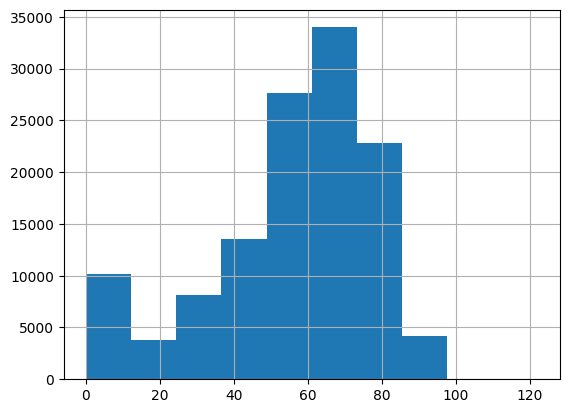

In [55]:
df_full["age"].hist()

<Axes: >

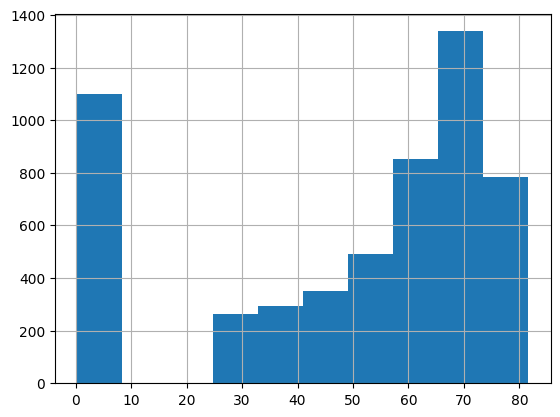

In [56]:
pd.Series(test_pred).hist()

In [57]:
test_pred.shape

(5475,)

In [58]:
test_pred

array([ 0.46852157,  4.49234325,  4.60417609, ..., 50.10467818,
       50.28259258, 52.83695504])

## Submission

In [59]:
submission = pd.read_csv(CFG.dataset_root_path + "submission.csv")
submission["AGE"] = test_pred
submission.to_csv(architecture_path + f"{architecture_name}_submission.csv", index=False)

In [60]:
submission

,FILENAME,GENDER,AGE
0,ecg_child_8781,FEMALE,0.468522
1,ecg_child_8782,MALE,4.492343
2,ecg_child_8783,MALE,4.604176
3,ecg_child_8784,FEMALE,5.368819
4,ecg_child_8785,FEMALE,0.332313
...,...,...,...
5470,ecg_adult_39536,FEMALE,31.693213
5471,ecg_adult_39537,FEMALE,58.393416
5472,ecg_adult_39538,FEMALE,50.104678
5473,ecg_adult_39539,FEMALE,50.282593
